In [1]:
!pip3 install git+https://github.com/Centre-automatique-et-systemes/lena.git gwpy &> /dev/null
!pip3 install git+https://github.com/aliutkus/torchinterp1d.git gwpy &> /dev/null

In [2]:
import sys ; sys.path.append('../')
from learn_KKL.luenberger_observer import LuenbergerObserver
from learn_KKL.system import VanDerPol
from learn_KKL.learner import Learner

In [3]:
# Generate the data
system = VanDerPol()
data = system.generate_mesh([-1., 1.], 50000)

# Create the observer (autoencoder design)
observer = LuenbergerObserver(dim_x=2, dim_y=1, method="Autoencoder", wc=1.5)
observer.set_dynamics(system)

# Train using the learner class
learner = Learner(observer,data)
learner.train()

====> Epoch: 1 done! LR: 0.001
====> Epoch: 2 done! LR: 0.001
====> Epoch: 3 done! LR: 0.001
====> Epoch: 4 done! LR: 0.001
====> Epoch: 5 done! LR: 0.001
====> Epoch: 6 done! LR: 0.0001
====> Epoch: 7 done! LR: 0.0001
====> Epoch: 8 done! LR: 0.0001
====> Epoch: 9 done! LR: 0.0001
====> Epoch: 10 done! LR: 0.0001
====> Epoch: 11 done! LR: 1e-05
====> Epoch: 12 done! LR: 1e-05
====> Epoch: 13 done! LR: 1e-05
====> Epoch: 14 done! LR: 1e-05
====> Epoch: 15 done! LR: 1e-05
====> Epoch: 16 done! LR: 1e-05
====> Epoch: 17 done! LR: 1e-05
====> Epoch: 18 done! LR: 1e-05
====> Epoch: 19 done! LR: 1e-05
====> Epoch: 20 done! LR: 1e-05


In [4]:
import torch 
tsim = (0, 60)
dt = 1e-2
tq, simulation = system.simulate(torch.tensor([[0.5], [-0.5]]), tsim, dt)
measurement = observer.h(
        simulation[:, :observer.dim_x, 0].T).T
y = torch.cat((tq.unsqueeze(1), measurement), dim=1)

# Predict from measurment
estimation = observer.predict(y, tsim, dt)

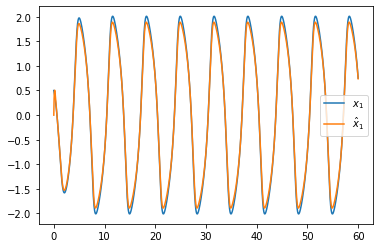

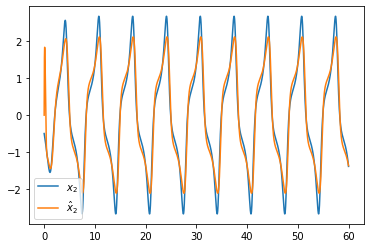

In [5]:
import matplotlib.pyplot as plt
# Plot ground truth and estimation
for i in range(simulation.shape[1]):
        plt.plot(tq, simulation[:, i, 0], label=rf'$x_{i+1}$')
        plt.plot(tq, estimation[:, i].detach().numpy(),
                 label=rf'$\hat{{x}}_{i+1}$')
        plt.legend()
        plt.show()